In [69]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

<Axes: title={'center': 'Train C'}, xlabel='time'>

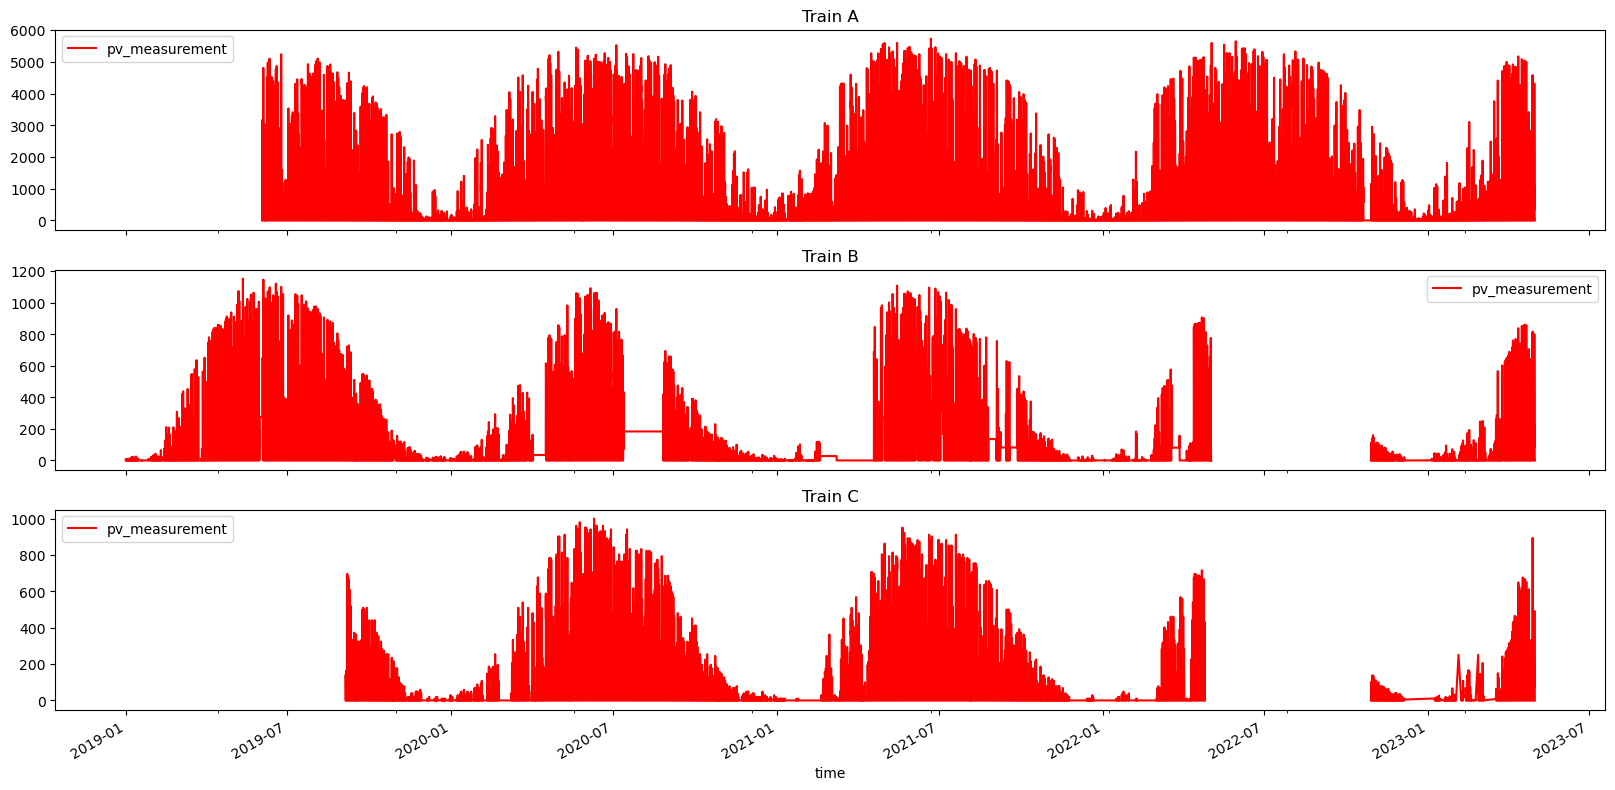

In [96]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
train_a[['time', "pv_measurement"]].set_index('time').plot(ax=axs[0], title='Train A', color='red')
train_b[['time', "pv_measurement"]].set_index('time').plot(ax=axs[1], title='Train B', color='red')
train_c[['time', "pv_measurement"]].set_index('time').plot(ax=axs[2], title='Train C', color='red')

In [108]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [203]:
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

In [267]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [ ]:
def split_labels(train, val, labels):

    train_end = train["date_forecast"][len(train)-1]
 
    labels["isTraining"] = [labels["time"][i].timestamp() < train_end.timestamp() for i in range(len(labels))]
    
    grouped = labels.groupby("isTraining")
    
    train_y = grouped.get_group(True)
    train_y = train_y.drop(['isTraining',], axis=1)
    
    val_y = grouped.get_group(False)
    val_y = val_y.drop(['isTraining',], axis=1)

    
    
    for label_i in range(len(labels)):
        time = labels["time"][label_i]
        for train_j in range(len(train)):
            date_forecast = train["date_forecast"][train_j]
            if date_forecast.year == time.year and date_forecast.month == time.month and date_forecast.day == time.day and date_forecast.hour == time.hour:
                break
        else:
            print(time)
        
    
    print(len(train), len(train_y))
    print(len(val), len(val_y))
    
    
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet') #Train_x
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet') # Val_x

train_x = quartersToHours(X_train_observed_a)
val_x = quartersToHours(X_train_estimated_a)


split_labels(train_x, val_x, train_a)

2022-10-21 01:00:00


In [256]:

print(len(train_a))
print(len(train_x) + len(val_x))

# Group training_data into hours
dataset = quartersToHours(X_train_observed_a)

# Remove wind speed as it is incorporated into the wind components
wind_speed = dataset.pop('wind_speed_10m:ms')

#Turn date into sin and cos
date_time = pd.to_datetime(dataset.pop('date_forecast'), format='%Y-%m.%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day
month = year / 12.0

dataset['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
dataset['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
dataset['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dataset['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# Normalize data
train_min = dataset.min()
train_max = dataset.max()

"""
plt.hist2d(dataset['wind_speed_u_10m:ms'], dataset['wind_speed_v_10m:ms'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')
"""
#plt.xlim(0, 118669)
#plt.plot(np.array(dataset['Year sin'])[:25])
#plt.plot(np.array(dataset['Year cos'])[:25])
#plt.xlabel('Time [d]')
#plt.title('Time of day signal')

df_std = (dataset - train_min) / (train_max - train_min)

#df_std = df_std.melt(var_name='Column', value_name='Normalized')
#plt.figure(figsize=(12, 6))
#ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
#_ = ax.set_xticklabels(dataset.keys(), rotation=90)

train_x

TypeError: 'DataFrame' object cannot be interpreted as an integer

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

In [8]:
test = pd.read_csv('test.csv')
test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [10]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [11]:
# Example, let the predictions be random values
test['prediction'] = np.random.rand(len(test))
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)